In [1]:
# import relevant modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import time
import sys
%matplotlib inline

from dipy.core.sphere import disperse_charges, HemiSphere
from dipy.core.gradients import gradient_table
from dipy.sims.voxel import multi_tensor
import dipy.reconst.dti as dti
import dipy.reconst.dki as dki

from dipy.sims.voxel import (multi_tensor, _add_gaussian, _add_rician,
                             _add_rayleigh)

from pca_utils import (rfiw_phantom, mp_distribution, fiber_segments_phantom)

In [2]:
# ---------------------------------------------------------------
# acquisition parameters
# ---------------------------------------------------------------

# Sample 8 diffusion-weighted directions for first shell
n_pts = 8
theta = np.pi * np.random.rand(n_pts)
phi = 2 * np.pi * np.random.rand(n_pts)
hsph_initial = HemiSphere(theta=theta, phi=phi)
hsph_updated, potential = disperse_charges(hsph_initial, 5000)
directions8 = hsph_updated.vertices  # directions for each shell

# Sample 30 diffusion-weighted directions for second shell
n_pts = 30
theta = np.pi * np.random.rand(n_pts)
phi = 2 * np.pi * np.random.rand(n_pts)
hsph_initial = HemiSphere(theta=theta, phi=phi)
hsph_updated, potential = disperse_charges(hsph_initial, 50000)
directions30 = hsph_updated.vertices  # directions for each shell

# Sample 60 diffusion-weighted directions for second shell
n_pts = 60
theta = np.pi * np.random.rand(n_pts)
phi = 2 * np.pi * np.random.rand(n_pts)
hsph_initial = HemiSphere(theta=theta, phi=phi)
hsph_updated, potential = disperse_charges(hsph_initial, 50000)
directions60 = hsph_updated.vertices  # directions for each shell

# Create full dataset parameters
bvals = np.hstack((np.zeros(6), 300 * np.ones(8),
                   1000 * np.ones(30), 2000 * np.ones(60)))
bvecs = np.vstack((np.zeros((6, 3)), directions8, directions30, directions60))
gtab = gradient_table(bvals, bvecs)

In [26]:
snr = 30
DWI = rfiw_phantom(gtab, snr=snr, noise_type='rician')

In [27]:
psize = 2
m = (2*psize + 1) ** 3
n = DWI.shape[3]
k = j = i = 5
X = DWI[i - psize: i + psize + 1, j - psize: j + psize + 1,
        k - psize: k + psize + 1, :]
X = X.reshape(m, n)
M = np.mean(X, axis=0)
X = X - M
[L, W] = np.linalg.eigh(np.dot(X.T, X)/m)
print(L)

[  1.05011936e-01   1.22673013e-01   1.83734890e-01   2.17993904e-01
   2.48904469e-01   2.77386474e-01   3.45328019e-01   4.38882802e-01
   4.92044063e-01   5.18222919e-01   5.85172684e-01   6.16556573e-01
   6.79430320e-01   7.56869325e-01   8.60732829e-01   1.00813672e+00
   1.11408725e+00   1.12832814e+00   1.16609538e+00   1.31032968e+00
   1.42735644e+00   1.49471883e+00   1.60482850e+00   1.74462469e+00
   1.96817068e+00   1.99517919e+00   2.18286493e+00   2.35751747e+00
   2.38389765e+00   2.68490653e+00   2.76595336e+00   2.88683968e+00
   3.10279402e+00   3.23403106e+00   3.38312998e+00   3.48778405e+00
   3.56139014e+00   3.94228610e+00   4.02776369e+00   4.23926089e+00
   4.38611837e+00   4.63697519e+00   4.70478121e+00   4.79155933e+00
   5.29623519e+00   5.46351486e+00   5.53452147e+00   5.80304214e+00
   6.02584756e+00   6.41516308e+00   6.57355335e+00   6.88309465e+00
   7.09829746e+00   7.38429707e+00   7.67262233e+00   7.92837833e+00
   8.07776464e+00   8.38770918e+00

In [5]:
def pca_denoising(dwi, psize=2):
    """ Denoises DWI volumes using PCA analysis and Marchenko–Pastur probability
    theory

    Parameters
    ----------
    dwi : array ([X, Y, Z, g])
        Matrix containing the 4D DWI data.
    psize : int
        Number of neighbour voxels for the PCA analysis.
        Default: 2

    Returns
    -------
    den : array ([X, Y, Z, g])
        Matrix containing the denoised 4D DWI data.
    """
    # Compute dimension of neighbour sliding window
    m = (2*psize + 1) ** 3

    n = dwi.shape[3]
    den = np.zeros(dwi.shape)
    for k in range(psize, dwi.shape[2] - psize):
        for j in range(psize, dwi.shape[1] - psize):
            for i in range(psize, dwi.shape[0] - psize):
                # Compute eigenvalues for sliding window
                X = dwi[i - psize: i + psize + 1, j - psize: j + psize + 1,
                        k - psize: k + psize + 1, :]
                X = X.reshape(m, n)
                M = np.mean(X, axis=0)
                X = X - M
                [L, W] = np.linalg.eigh(np.dot(X.T, X)/m)
                
                Y = X.dot(W[:, -nep:])
                X = Y.dot(W[:, -nep:].T)
                X = X + M
                X = X.reshape(2*psize + 1, 2*psize + 1, 2*psize + 1, n)
                den[i, j, k, :] = X[psize, psize, psize]
    return den, ncomps, sig

In [76]:
def pca_noise_classifier(L):
    """ Classify which PCA eigenvalues are related to noise

    Parameters
    ----------
    L : array (n,)
        Array containing the PCA eigenvalues.

    Returns
    -------
    p 
    var """
    n = L.size
    r = np.zeros(n)
    a = np.zeros(n)
    for c in range(2, n):
        sig2 = np.mean(L[:c])
        r[c] = L[c] - L[0] - 4*np.sqrt((c + 1)*1.0/125)*sig2
        #r[c] = 4*np.sqrt(c*1.0/125)*sig2
        #r[c] = sig2
        a[c] = L[c] - L[0]
    return r, a

[  0.00000000e+00   0.00000000e+00   1.28936511e-02   2.17721213e-02
   1.71790749e-02   9.26338476e-02   8.00198263e-02   1.01302001e-01
   9.57630240e-02   1.88482483e-01   1.39405529e-01   2.96193486e-01
   2.40238878e-01   2.94652703e-01   2.67257083e-01   2.17819631e-01
   2.49437328e-01   3.30537860e-01   3.60954961e-01   3.46886104e-01
   3.76646467e-01   4.06269293e-01   3.91610805e-01   3.72032494e-01
   5.26927774e-01   4.85856904e-01   4.12909391e-01   5.78687812e-01
   6.91366262e-01   7.72695968e-01   7.69121088e-01   6.45415599e-01
   6.65037540e-01   5.88238397e-01   8.05187558e-01   6.57146811e-01
   6.95247437e-01   7.06181399e-01   8.42938369e-01   7.61201023e-01
   9.01425648e-01   8.85651672e-01   7.92037879e-01   7.12698513e-01
   6.01829164e-01   7.12300592e-01   6.05369087e-01   4.56619149e-01
   4.22204501e-01   2.17755605e-01   3.08331144e-01   1.43733719e-01
   2.88046610e-01   2.76136672e-01   5.40798468e-02   2.61967317e-02
   6.64341189e-02  -1.70141073e-01

[90, 110, -5, 20]

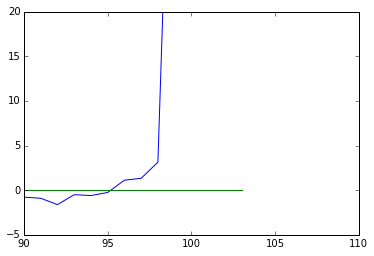

In [79]:
print r
r, a = pca_noise_classifier(L)
plt.plot(range(104), r)
plt.plot(range(104), np.zeros(104))
plt.axis([90, 110, -5, 20])

Test another phaton

In [50]:
from dipy.sims.voxel import (multi_tensor, _add_gaussian, _add_rician,
                             _add_rayleigh)
fsigma = 20.0
Phantom = fiber_segments_phantom(gtab, fsigma)
snr = 15
sigma = 50.0 /snr
n1 = np.random.normal(0, sigma, size=Phantom.shape)
n2 = np.random.normal(0, sigma, size=Phantom.shape)
PDen = _add_rician(Phantom.copy(), n1, n2)

In [51]:
psize = 2
m = (2*psize + 1) ** 3
n = PDen.shape[3]
k = j = i = 5
X = PDen[i - psize: i + psize + 1, j - psize: j + psize + 1,
        k - psize: k + psize + 1, :]
X = X.reshape(m, n)
M = np.mean(X, axis=0)
X = X - M
[L, W] = np.linalg.eigh(np.dot(X.T, X)/m)

[  0.00000000e+00   0.00000000e+00   2.93106373e-02   3.75508237e-02
   3.27195467e-02   1.07951908e-01   9.61016631e-02   1.17862150e-01
   1.12904993e-01   2.06107967e-01   1.57997708e-01   3.15420620e-01
   2.60730195e-01   3.16094193e-01   2.89779444e-01   2.41283714e-01
   2.73673884e-01   3.55614995e-01   3.87047460e-01   3.74037487e-01
   4.04809720e-01   4.35487704e-01   4.21925202e-01   4.03410977e-01
   5.59337776e-01   5.19519533e-01   4.47764159e-01   6.14642894e-01
   7.28626855e-01   8.11391576e-01   8.09339413e-01   6.87153049e-01
   7.08176076e-01   6.32805849e-01   8.51126130e-01   7.04657254e-01
   7.44219793e-01   7.56662242e-01   8.94953363e-01   8.14868668e-01
   9.56706783e-01   9.42662112e-01   8.50787982e-01   7.73151548e-01
   6.63961335e-01   7.76072989e-01   6.70873051e-01   5.23824189e-01
   4.91061254e-01   2.88278186e-01   3.80449550e-01   2.17526814e-01
   3.63471104e-01   3.53295294e-01   1.33003532e-01   1.06825545e-01
   1.48794485e-01  -8.59935626e-02

[0, 110, -5, 10]

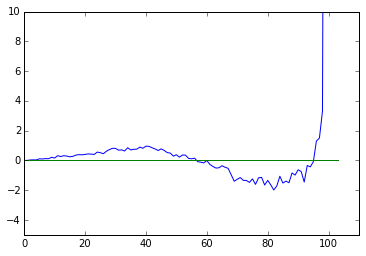

In [69]:
r, a = pca_noise_classifier(L)
print r
plt.plot(range(104), r)
plt.plot(range(104), np.zeros(104))
plt.axis([0, 110, -5, 10])

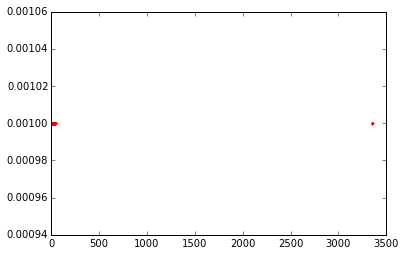

In [14]:
y = n*1.0/m
x = np.linspace(0, 500, num=100)
plt.plot(L, 0.001*np.ones(L.shape), '.r')
#plt.axis([-10, 1400, 0, 0.05])
plt.show()

In [56]:
50/15

3

In [98]:
def pca_noise_classifier(L, m):
    """ Classify which PCA eigenvalues are related to noise

    Parameters
    ----------
    L : array (n,)
        Array containing the PCA eigenvalues.

    Returns
    -------
    c : int
        Number of eigenvalues related to noise
    sig2 : float
        Estimation of the noise variance
    """
    sig2 = np.mean(L)
    c = L.size - 1
    r = L[c] - L[0] - 4 * np.sqrt((c+1.0) / m) * sig2
    while r > 0:
        sig2 = np.mean(L[:c])
        c = c - 1
        r = L[c] - L[0] - 4*np.sqrt((c+1.0) / m) * sig2
    return c + 1, sig2

In [101]:
def pca_denoising(dwi, psize=2):
    """ Denoises DWI volumes using PCA analysis and Marchenko–Pastur
    probability theory

    Parameters
    ----------
    dwi : array ([X, Y, Z, g])
        Matrix containing the 4D DWI data.
    psize : int
        Number of neighbour voxels for the PCA analysis.
        Default: 2

    Returns
    -------
    den : array ([X, Y, Z, g])
        Matrix containing the denoised 4D DWI data.
    std : array ([X, Y, Z])
        Matrix containing the noise std estimated using
        Marchenko-Pastur probability theory.
    """
    # Compute dimension of neighbour sliding window
    m = (2*psize + 1) ** 3

    n = dwi.shape[3]
    den = np.zeros(dwi.shape)
    ncomps = np.zeros(dwi.shape[:3])
    sig2 = np.zeros(dwi.shape[:3])

    for k in range(psize, dwi.shape[2] - psize):
        for j in range(psize, dwi.shape[1] - psize):
            for i in range(psize, dwi.shape[0] - psize):
                # Compute eigenvalues for sliding window
                X = dwi[i - psize: i + psize + 1, j - psize: j + psize + 1,
                        k - psize: k + psize + 1, :]
                X = X.reshape(m, n)
                M = np.mean(X, axis=0)
                X = X - M
                [L, W] = np.linalg.eigh(np.dot(X.T, X)/m)

                # Find number of noise related eigenvalues
                c, sig = pca_noise_classifier(L, m)
                ncomps[i, j, k] = c
                sig2[i, j, k] = sig

                # Reconstruct signal without noise components
                Y = X.dot(W[:, c:])
                X = Y.dot(W[:, c:].T)
                X = X + M
                X = X.reshape(2*psize + 1, 2*psize + 1, 2*psize + 1, n)
                den[i, j, k, :] = X[psize, psize, psize]

    return den, np.sqrt(sig2), ncomps

In [102]:
c, sig = pca_noise_classifier(L, 125)
print c
print sig

96
9.63147405761


In [103]:
np.sqrt(sig)

3.103461624961628

In [104]:
L[:104].size

104

2.0
